In [9]:
import pandas as pd
import numpy as np



data = pd.read_csv('train.csv')
# print(data)
data = np.array(data)
m ,n = data.shape
np.random.shuffle(data)


# test.shape = (784,1)
# test = np.array(list(map(lambda el:[el], test)))
# print(test)
# test = transform.resize(test, (1, 784))

def min_max_normalize(set : np.array):
    return (set - np.min(set))/(np.max(set) - np.min(set))

# print(data)
data_train = data[0:int(3*m/4)].T
# data_train = data.T
labels_train = data_train[0]
x_train = data_train[1:n]
# print(x_train.shape)
x_train = min_max_normalize(x_train).round()

data_test = data[int(3*m/4):m].T
labels_test = data_test[0]
x_test = data_test[1:n]
x_test = min_max_normalize(x_test).round()

# x_test = x_test.join(test.T)



# x_train = x_train / 255.0
# np.random.shuffle(x_train)
# print(f'labels {labels_train}')
# print(x_train)

# x_train.shape
layer2 = 128
layer3 = 64
def init_params():
    print('initializing...')
    w1 = np.random.rand(layer2,784) - 0.5
    b1 = np.random.rand(layer2,1) - 0.5
    w2 = np.random.rand(layer3,layer2) - 0.5
    b2 = np.random.rand(layer3,1) - 0.5
    w3 = np.random.rand(10,layer3)- 0.5
    b3 = np.random.rand(10,1)- 0.5
    return w1, b1, w2, b2, w3, b3

def RelU(z):
    relU = np.maximum(z, 0)
    return relU

def sigmoid(z):
    e_negx = np.exp(-z)
    sigmoid = 1 / (1 + e_negx)
    return sigmoid

def softmax(z):
    e_z = np.exp(z)
    softmax = e_z/sum(e_z)
    return softmax

def forward_prop(x,w1,b1,w2,b2,w3,b3):
    z1 = w1.dot(x) + b1
    a1 = RelU(z1)
    z2 = w2.dot(a1) + b2
    a2 = sigmoid(z2)
    z3 = w3.dot(a2) + b3
    a3 = softmax(z3)
    # print(a2.shape)
    
    return z1, a1, z2, a2, z3, a3


def one_hot(y):
    one_hot = np.zeros((y.size, y.max() + 1))
    one_hot[np.arange(y.size), y] = 1
    one_hot = one_hot.T
    return one_hot

def deriv_RelU(z):
    return z > 0
    # return np.where(z > 0, 1, 0)

def deriv_sigmoid(z):
    sig = sigmoid(z)
    deriv = sig*(1-sig)
    return deriv



def back_prop(a1, w1, z1, a2, w2, z2, a3, w3, z3, x, y):
    one_hot_y = one_hot(y)
    
    m = y.size
#     C0 = np.zeroes(10,1)
    dz3 = a3 - one_hot_y
    # print(error2[0])
    dw3 = dz3.dot(a2.T)/m
    db3 = np.sum(dz3)/m

    error2 = w3.T.dot(dz3) * deriv_sigmoid(z2)
    dw2 = error2.dot(a1.T)/m
    db2 = np.sum(error2)/m

    error1 = w2.T.dot(error2) * deriv_RelU(z1)
    dw1 = error1.dot(x.T)/m
    db1 = np.sum(error1)/m
    
    return dw1, db1, dw2, db2, dw3, db3


def update_params(w1, b1, w2, b2, w3, b3, dw1, db1, dw2, db2, dw3, db3, rate):
#     print(f'first : w1, b1, w2, b2 : {w1} {b1} {w2} {b2}')
    w1 = w1 - rate * dw1
    b1 = b1 - rate * db1
    w2 = w2 - rate * dw2
    b2 = b2 - rate * db2
    w3 = w3 - rate * dw3
    b3 = b3 - rate * db3
    
#     print(f'changed: w1, b1, w2, b2 : {w1} {b1} {w2} {b2}')

    return w1, b1, w2, b2, w3, b3

def get_predictions(a):
    return np.argmax(a, 0)

def get_accuracy(predictions, y):
    return np.sum(predictions == y) / y.size, np.sum(y**2-predictions**2) / y.size

import itertools

def gradient_descent(x, y, iterations, rate, w1=None, b1=None, w2=None, b2=None, w3=None, b3=None):
    xLoss = []
    yAcc = []

    if not isinstance(w1, np.ndarray):
        w1, b1, w2, b2, w3, b3 = init_params()
    # last_accuracy = 0
    # first = 0
    load = '----------------------------------------------------------|'
    # bar = ''

    # dist = ''
    for iteration in range(iterations):
    # iteration = 0
    # for _ in itertools.repeat(iteration, iterations):
        # iteration += 1
        z1, a1, z2, a2, z3, a3 = forward_prop(x, w1, b1, w2, b2, w3, b3)
        dw1, db1, dw2, db2, dw3, db3 = back_prop(a1, w1, z1, a2, w2, z2, a3, w3, z3, x, y)
        w1, b1, w2, b2, w3, b3 = update_params(w1, b1, w2, b2, w3, b3, dw1, db1, dw2, db2, dw3, db3, rate)

        dist = int((len(load)*iteration)/iterations)
        bar = ['*']*dist
        loader = [*load]
        loader[0:dist] = bar
        load = ''.join(loader)
       
        accuracy, loss = get_accuracy(get_predictions(a3), y)
        xLoss.append(loss)
        yAcc.append(accuracy)
        if iteration < iterations-1:
            print(f'{load} {accuracy} {loss}', end='\r')
        else:
            print(f'{load} {accuracy} {loss} complete')

    return w1, b1, w2, b2, w3, b3, np.array(xLoss), np.array(yAcc)



def make_predictions(x, w1, b1, w2, b2, w3, b3):
    _, _, _, _, _, a3 = forward_prop(x, w1, b1, w2, b2, w3, b3)
    predictions = get_predictions(a3)
    return predictions



In [10]:
from skimage import io, transform, color
import cv2


image = cv2.imread('board.png')
# if image.shape[2] == 4:
#     image = color.rgb2gray(color.rgba2rgb(image))
# else: 
#     image = color.rgb2gray(image)
image = cv2.bitwise_not(image)
# print(np.array(image).shape)

# image = transform.resize(image, (28, 28))

image = color.rgb2gray(image)

def split_grid(image : np.array):
    m, n = image.shape
    one = image[0:int(m/3),0:int(n/3)]
    two = image[0:int(m/3),int(n/3):int(2*n/3)]
    three = image[0:int(m/3),int(2*n/3):n]

    four = image[int(m/3):int(2*m/3),0:int(n/3)]
    five = image[int(m/3):int(2*m/3),int(n/3):int(2*n/3)]
    six = image[int(m/3):int(2*m/3),int(2*n/3):n]

    seven = image[int(2*m/3):int(m),0:int(n/3)]
    eight = image[int(2*m/3):int(m),int(n/3):int(2*n/3)]
    nine = image[int(2*m/3):int(m),int(2*n/3):n]

    return one, two, three, four, five, six, seven, eight, nine

squares = list(split_grid(image))
nine = squares[8]

spaces = list(split_grid(nine))


def get_pixels(image : np.array, show = False):
    image = transform.resize(image, (28, 28))
    pixels = np.array(image.flatten())
    if show: 
        print(pixels)

    return image, np.array([pixels])

# print(image2.shape)
# io.imshow(image2)
# io.show()

In [11]:
directory = 'assets'

import os

# print(picture)
# io.imshow(picture)
# io.show()

def create_entry(pixels : np.array, label : str, set : list):
    pixels = pixels.tolist()[0]
    # print(pixels)
    # print(label, type(pixels))
    pixels.extend([label])
    # print(pixels)
    # pixels = np.append(pixels, ), 1)

    set.append(pixels)
    
    return pixels, set


In [12]:

digits = []
print('loading files...')
for folder in os.listdir(directory):
    f = os.path.join(directory, folder)

    # print(f)
    for file in os.listdir(f):
        picture = None
        file_name = os.path.join(f, file)
        # print(file)
        if os.path.isfile(file_name):
            # print(file_name)
            picture = cv2.imread(file_name)
            picture = color.rgb2gray(picture)

            _, pixels = get_pixels(picture)
            pixels = pixels
            label = int(file_name[7])
            _, digits = create_entry(pixels, label, digits)

                # print(digits)
                # io.imshow()
                # io.show()
                # print(label, len(entry))
        
digits = np.array(digits)
np.random.shuffle(digits)
# one = digits[0:2]




loading files...


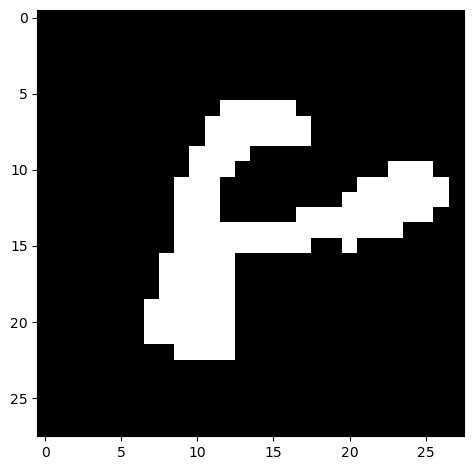

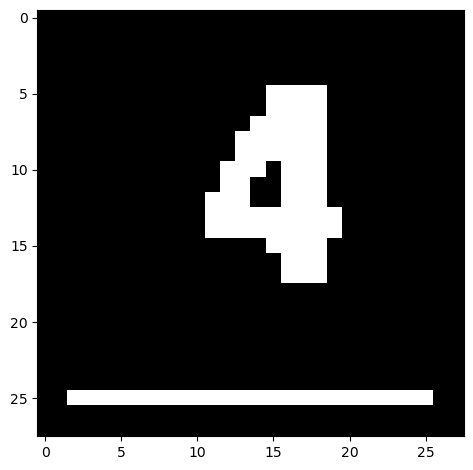

In [13]:

m, n = digits.shape
digits = digits.round()
digit_train = digits.T
digit_labels = digit_train[-1]
x_digit_train = digit_train[0:n-1]
first_digit = x_digit_train[:,1]
first = x_train[:,1]
# x_digit_train = min_max_normalize(digit_train[0:n-1])
# print(first_digit[first_digit != 0], first[first != 0], first_digit.shape == first.shape)
# first = first.round()
io.imshow(first.reshape(28,28))
io.show()
io.imshow(first_digit.reshape(28,28))
io.show()

test = np.array(pd.read_csv('test.csv')).T
test = min_max_normalize(test)


In [14]:

def add_to_test(test, pixels):
    # print('added')
    return np.append(test, pixels.T, 1)

grid_labels = np.array([0, 7, 0, 0, 0, 0,0,3,0,8,3,0,4,0,0,0,0,0,0,4,1,0,0,7,0,0,0,0,4,0,0,2,1,0,0,5,7,0,0,3,0,0,0,0,0,0,6,0,4,0,8,0,0,0,9,0,0,0,0,8,0,0,0,0,0,5,0,0,0,0,0,0,2,8,0,0,0,0,1,0,9])
print(len(grid_labels))
def format_board(test):
    image = cv2.imread('board.png')
    image = cv2.bitwise_not(image)

    image = color.rgb2gray(image)
    # image = image.round()

    io.imshow(image)
    io.show()

    grids = list(split_grid(image))
    mini_grids = []
    for grid in grids:
        spaces = list(split_grid(grid))
        mini_grids.append(spaces)
        for space in spaces:
            # io.imshow(space)
            # io.show()
            # label = grid_labels[i]
            test = add_to_test(test, get_pixels(space)[1])

    return mini_grids, test


81


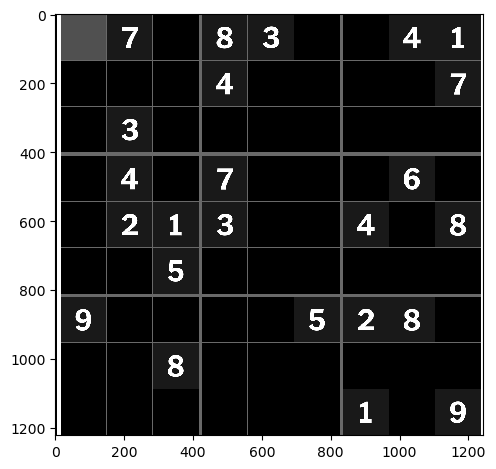

(784, 81)


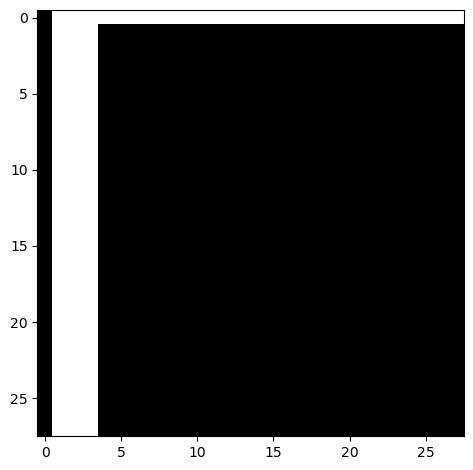

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 784


In [15]:

# print('test size' , test.shape)
grids, test = format_board(test)
# print(grids)
# print('test size' , test.shape)
m, n = test.shape
board_squares = test[:, 28000:n]
print(board_squares.shape)
board_squares = board_squares.round()
# io.imshow(board_squares.reshape())
io.show()
space = board_squares[:,0]
io.imshow(space.reshape(28,28))
io.show()

print(space[space != 0], len(board_squares[:,0]))


In [16]:
from matplotlib import pyplot as plt
mnist_rate = .04
# iters = 500
# iters = 800

# from three_hidden import gradient_descent

w1, b1, w2, b2, w3, b3, w4, b4, lossY, accY = gradient_descent(x_train, labels_train, 1000, mnist_rate)
# # print(w1, b1, w2, b2, w3, b3)
# firstX = np.arange(start=1, stop=iters)
# plt.plot(lossY)
w1, b1, w2, b2, w3, b3, w4, b4, lossY2, accY2 = gradient_descent(x_train, labels_train, 1500, mnist_rate-0.005, w1, b1, w2, b2, w3, b3, w4, b4)

# display(lossY)
plt.plot(np.append(lossY,lossY2))
plt.title('Loss')
plt.show()
plt.plot(np.append(accY,accY2)*100)
plt.title('Accuracy')
plt.show()
# firstY = 



preds = make_predictions(x_test, w1, b1, w2, b2, w3, b3, w4, b4)
display(preds) 
display(labels_test)
mnist_acc, mnist_loss = get_accuracy(preds, labels_test)
print(f'test accuracy : {get_accuracy(preds, labels_test)}')

# prev : 800
digit_rate = .1
w1, b1, w2, b2, w3, b3, digiLossY, accY = gradient_descent(x_digit_train, digit_labels.astype(int), 1000, digit_rate, w1, b1, w2, b2, w3, b3)
w1, b1, w2, b2, w3, b3, digiLossY2, accY2 = gradient_descent(x_digit_train, digit_labels.astype(int), 4000, digit_rate-.01, w1, b1, w2, b2, w3, b3)
# w1, b1, w2, b2, w3, b3, digiLossY3, accY3 = gradient_descent(x_digit_train, digit_labels.astype(int), 300, .07, w1, b1, w2, b2, w3, b3)
plt.plot(np.append(digiLossY,digiLossY2))
plt.title('Loss')
plt.show()
plt.plot(np.append(accY,accY2)*100)
plt.title('Accuracy')
plt.show()
# # print(w1, b1, w2, b2, w3, b3)


initializing...
**********************************************************| 0.8336507936507936 0.2125079365079365 complete


ValueError: not enough values to unpack (expected 10, got 8)

In [ ]:
# w1, b1, w2, b2, w3, b3, digiLossY, accY = gradient_descent(x_digit_train, digit_labels.astype(int), 1600, .01, w1, b1, w2, b2, w3, b3)
# plt.plot(digiLossY)
# plt.show()
# plt.plot(accY*100)
# plt.show()

[5 7 0 9 0 0 9 3 0 8 3 0 4 0 0 0 0 0 0 4 1 0 0 2 0 0 2 9 4 0 9 2 1 9 0 5 7
 0 0 3 0 0 0 0 0 0 6 0 4 0 8 0 0 0 9 0 0 9 0 8 9 0 0 0 0 3 0 0 0 0 0 0 3 6
 0 0 0 0 1 0 9] 
 [0 7 0 0 0 0 0 3 0 8 3 0 4 0 0 0 0 0 0 4 1 0 0 7 0 0 0 0 4 0 0 2 1 0 0 5 7
 0 0 3 0 0 0 0 0 0 6 0 4 0 8 0 0 0 9 0 0 0 0 8 0 0 0 0 0 5 0 0 0 0 0 0 2 8
 0 0 0 0 1 0 9]
test accuracy : 0.8395061728395061 -6.320987654320987


array([[False,  True,  True, False,  True,  True, False,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True, False,  True,  True, False],
       [False,  True,  True, False,  True,  True, False,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True,  True, False,  True,  True],
       [ True,  True, False,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True]])

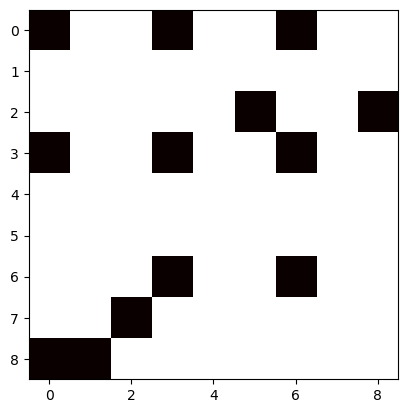

{'hiddenlayer1 neurons': 128, 'hiddenlayer2 neurons': 64, 'mnist learning rate': 0.04, 'digits learning rate': 0.1, 'mnist final accuracy': 0.878, 'mnist loss': 0.3518095238095238, 'digit final accuracy': 0.9793294270833334, 'digit loss': -6.320987654320987, 'puzzle accuracy': 0.8395061728395061}


In [ ]:

preds = make_predictions(board_squares, w1, b1, w2, b2, w3, b3, w4, b4)
print(f'{preds} \n {grid_labels}')
digit_acc, digit_loss = get_accuracy(preds, grid_labels)
# print(preds == grid_labels)
print(f'test accuracy : {digit_acc} {digit_loss}')
indexes = [j + 1 for j in range(preds.shape[0])]

map = (preds == grid_labels).reshape(9,9)
display(map)
preds = zip(indexes, preds)
submission = pd.DataFrame(preds, columns = ['ImageID', 'Label'])

# np.savetxt('puzzle_accuracy.csv',np.array([grid_accuracy]), fmt='%.2f')
    
submission.to_csv('puzzle.csv', index=False)
plt.imshow(map, cmap='hot')
plt.show()


results = {
    'hiddenlayer1 neurons' : layer2,
    'hiddenlayer2 neurons' : layer3,
    'mnist learning rate' : mnist_rate,
    'digits learning rate' : digit_rate,
    'mnist final accuracy' : mnist_acc,
    'mnist loss' : mnist_loss,
    'digit final accuracy' : accY2[-1],
    'digit loss' : digit_loss,
    'puzzle accuracy' : digit_acc
}

print(results)
data = pd.DataFrame([results], columns=None)

data.to_csv('training.csv', mode='a')

# display(pd.DataFrame(w1, columns=None))

# weights.to_csv('weights.csv', index = False)


# best 97% : 1st train .1, 600, 2nd train .15, 800 , and rounded values for both sets

# 95% 97% : 1st train .12, 700, 2nd train .15, 1300 , and rounded values for both sets


In [ ]:
# pd.DataFrame(w1).to_csv('w1.csv', index=False)
# pd.DataFrame(b1).to_csv('b1.csv', index=False)
# pd.DataFrame(w2).to_csv('w2.csv', index=False)
# pd.DataFrame(b2).to_csv('b2.csv', index=False)
# pd.DataFrame(w3).to_csv('w3.csv', index=False)
# pd.DataFrame(b3).to_csv('b3.csv', index=False)

In [ ]:
training = pd.read_csv('training.csv')
display(training)

,Unnamed: 0,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy
0,0.0,52,52,0.04,0.03,0.8852380952380953,-0.056857142857142856,0.6799740344044142,-1.0987654320987654,0.9135802469135802
1,NaN,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy
2,0.0,52,28,0.04,0.03,0.8672380952380953,0.15276190476190477,0.6471924699772801,-3.814814814814815,0.9135802469135802
3,NaN,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy
4,0.0,52,28,0.03,0.03,0.8562857142857143,0.23457142857142857,0.6815968841285297,-1.8148148148148149,0.9135802469135802
5,NaN,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy
6,0.0,52,28,0.03,0.03,0.8562857142857143,0.23457142857142857,0.6815968841285297,-1.8148148148148149,0.9135802469135802
7,NaN,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy
8,0.0,52,28,0.04,0.04,0.8775238095238095,-0.0440952380952381,0.7502434274586174,-2.0617283950617282,0.8765432098765432
9,NaN,hiddenlayer1 neurons,hiddenlayer2 neurons,mnist learning rate,digits learning rate,mnist final accuracy,mnist loss,digit final accuracy,digit loss,puzzle accuracy


In [ ]:
# preds = make_predictions(board_squares, w1, b1, w2, b2, w3, b3)
# print(f'{preds} \n {grid_labels}')
# grid_accuracy = get_accuracy(preds, grid_labels)
# # print(preds == grid_labels)
# print(f'test accuracy : {grid_accuracy}')
# indexes = [j + 1 for j in range(preds.shape[0])]

# map = (preds == grid_labels).reshape(9,9)
# display(map)
# display(grid_labels.reshape(9,9))
# preds = zip(indexes, preds)
# submission = pd.DataFrame(preds, columns = ['ImageID', 'Label'])

# np.savetxt('puzzle_accuracy.csv',np.array([grid_accuracy]), fmt='%.2f')
    
# submission.to_csv('puzzle.csv', index=False)
# plt.imshow(map, cmap='hot')
# plt.show()